In [1]:
from brian2 import *
from util.visualization_functions import *
%matplotlib inline
prefs.codegen.target = "numpy" # delete if get c++ build tools working

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: "_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)"
 [brian2.codegen.generators.base]
INFO       Failed to vectorise code, falling back on Python loop: note that this will be very slow! Switch to another code generation target for best performance (e.g. cython or weave). First line is: _Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant) [brian2.codegen.generators.numpy_generator]


Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s
[0.     0.2048 0.3581 0.7506 0.8582 0.8855] s


Text(0, 0.5, 'Neuron')

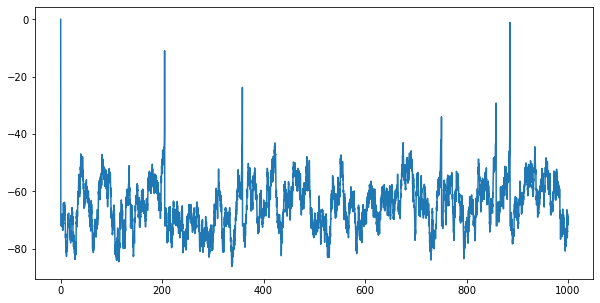

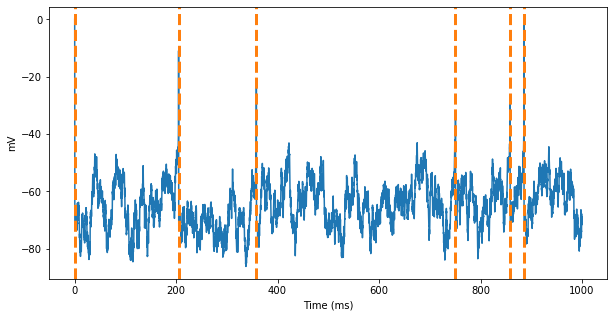

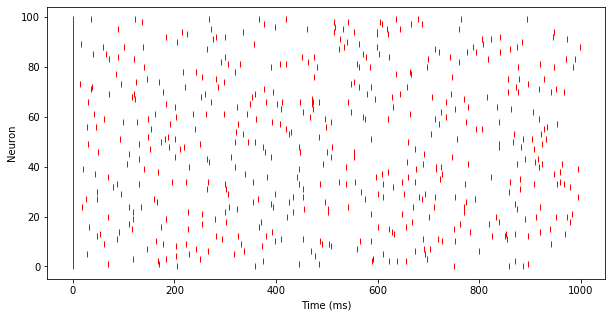

In [2]:
# trying to recreate the simulation used in Ocker 2015

start_scope()

# model parameters
gL = .1 * msiemens * cm**-2 # leak conductance
vL = -72 * mV               # leak reversal potential
C = 1 * ufarad * cm**-2     # membrane capacitance
delta = 1.4 * mV            # action potential steepness
vT = -48 * mV               # action potential initiation threshold
mu = 1 * uamp * cm**-2      # noise mean
sigma = 9 * mV              # noise std dev

# other cell params
vTh = 30 * mV               # spike threshold
vR = -72 * mV               # reset potential
tRef = 2 * ms               # action potential width (refractory time)

# network params
p = 0.15                    # connection density
N = 100                     # number of neurons

# stdp params
wMax = 0.0335               # max syn weight - TODO: generate wMax from connectivity stats like in paper?
deleps = -wMax / 50000      # ??? - no idea what this is but it appears in the paper's par_net.m file
tauPre = 15 * ms            # synaptic time constant
tauPost = 2 * tauPre        # synaptic time constant
dApost = -wMax / 5000       # f neg (f post)
dApre = (-dApost * tauPost + deleps * tauPost) / tauPre # f pos (f pre)

# model
dynamics = '''
dv/dt = (gL * (vL - v) + gL * delta * exp((v - vT) / delta) + (mu + gL * sigma * sqrt(2 * C / gL) * xi)) / C : volt (unless refractory)
'''

G = NeuronGroup(N, dynamics, 
                threshold='v > vTh',
                reset='v = vR',
                refractory='tRef',
                method='euler')

S = Synapses(G, G,
             '''w : 1
                dApre/dt = -Apre / tauPre : 1 (event-driven)
                dApost/dt = -Apost / tauPost : 1 (event-driven)''',
             on_pre='''v += w * v
                    Apre += dApre
                    w = clip(w + Apost, 0, wMax)''',
             on_post='''Apost += dApost
                     w = clip(w + Apre, 0, wMax)'''
            )
           
# TODO: initialize mean weight over some distribution?
S.connect(condition='i!=j', p=p)
S.w = '0.2'

# monitors
M = StateMonitor(G, 'v', record=True)
sp_mon_excit = SpikeMonitor(G)

# initial value
#G.v = 5 * mV 

# run
run(1000*ms, report='text')

# plots
#visualise_connectivity(S)

plt.figure(figsize=(10, 5))
plot(M.t/ms, M.v[0]/mV)
    
plt.figure(figsize=(10, 5))
plot(M.t/ms, M.v[0]/mV)

n0SpikeTrain = sp_mon_excit.spike_trains()[0]
for t in n0SpikeTrain:
    axvline(t/ms, ls='--', c='C1', lw=3)
print(n0SpikeTrain)


xlabel('Time (ms)')
ylabel('mV')

plt.figure(figsize=(10, 5))
plot(sp_mon_excit.t/ms, sp_mon_excit.i, '|r')
xlabel('Time (ms)')
ylabel('Neuron')


In [5]:
# connectivity matrix?
print(S.w)
print(len(S.w))

# Create a matrix to store the weights and fill it with NaN
W = np.full((len(G), len(G)), np.nan)

# Insert the values from the Synapses object
W[S.i[:], S.j[:]] = S.w[:]

<synapses.w: array([0.0334948 , 0.03349757, 0.0335    , ..., 0.03349276, 0.03349782,
       0.03349133])>
1508


-1.e-05 m^-2 A
30. ms
-3.e-07 C/m^2
-1.e-06 m^-2 A


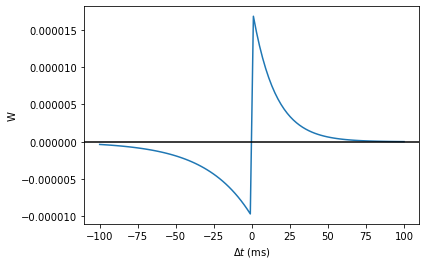

In [2]:
from brian2.units import *

# stdp params
wMax = 5 * uamp * cm**-2    # max syn weight
deleps = -wMax / 50000      # ???
tauPre = 15 * ms            # synaptic time constant
tauPost = 2 * tauPre        # synaptic time constant
dApost = -wMax / 5000       # f neg (f post)

print(dApost)
print(tauPost)
print(dApost * tauPost)

print(deleps)

dApre = (-dApost * tauPost + deleps * tauPost) / tauPre # f pos (f pre)

# plot
visualize_stdp(dApre, tauPre, dApost, tauPost)

-6.7e-06
30. ms
-201. ns
-6.7e-07


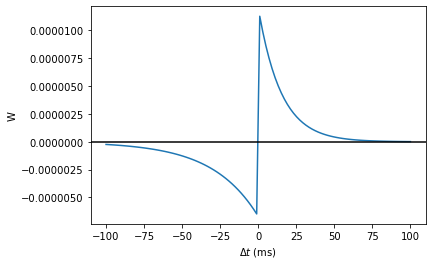

In [3]:
# dimensionless stdp params
wMax = 0.0335               # max syn weight
deleps = -wMax / 50000      # ???
tauPre = 15 * ms            # synaptic time constant
tauPost = 2 * tauPre        # synaptic time constant
dApost = -wMax / 5000       # f neg (f post)

print(dApost)
print(tauPost)
print(dApost * tauPost)

print(deleps)

dApre = (-dApost * tauPost + deleps * tauPost) / tauPre # f pos (f pre)

# plot
visualize_stdp(dApre, tauPre, dApost, tauPost)